#Install and import necessary library

In [ ]:
!pip install pyvi
!pip install vncorenlp
!pip install transformers

     |████████████████████████████████| 8.5 MB 3.9 MB/s 
     |████████████████████████████████| 965 kB 34.6 MB/s 
     |████████████████████████████████| 2.6 MB 4.2 MB/s 
  Created wheel for vncorenlp: filename=vncorenlp-1.0.3-py3-none-any.whl size=2645951 sha256=5b025154a7e2fd647c3bc3eb07b51fdd9c293cdf9718216ca9938944054d6646
  Stored in directory: /root/.cache/pip/wheels/0c/d8/f2/d28d97379b4f6479bf51247c8dfd57fa00932fa7a74b6aab29
Successfully built vncorenlp
     |████████████████████████████████| 4.0 MB 4.8 MB/s 
     |████████████████████████████████| 596 kB 37.4 MB/s 
     |████████████████████████████████| 6.6 MB 8.2 MB/s 
     |████████████████████████████████| 895 kB 15.3 MB/s 
     |████████████████████████████████| 77 kB 5.8 MB/s 
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13


In [ ]:
#Download VncoreNLP
!mkdir -p vncorenlp/models/wordsegmenter
!wget -q --show-progress https://raw.githubusercontent.com/vncorenlp/VnCoreNLP/master/VnCoreNLP-1.1.1.jar
!wget -q --show-progress https://raw.githubusercontent.com/vncorenlp/VnCoreNLP/master/models/wordsegmenter/vi-vocab
!wget -q --show-progress https://raw.githubusercontent.com/vncorenlp/VnCoreNLP/master/models/wordsegmenter/wordsegmenter.rdr
!mv VnCoreNLP-1.1.1.jar vncorenlp/ 
!mv vi-vocab vncorenlp/models/wordsegmenter/
!mv wordsegmenter.rdr vncorenlp/models/wordsegmenter/

In [ ]:
#Download PhoBert model to vectorize
from transformers import AutoModel, AutoTokenizer

phobert = AutoModel.from_pretrained("vinai/phobert-base")

# For transformers v4.x+: 
tokenizer = AutoTokenizer.from_pretrained("vinai/phobert-base", use_fast=False)

Downloading:   0%|          | 0.00/557 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/518M [00:00<?, ?B/s]

Some weights of the model checkpoint at vinai/phobert-base were not used when initializing RobertaModel: ['lm_head.bias', 'lm_head.layer_norm.weight', 'lm_head.dense.bias', 'lm_head.dense.weight', 'lm_head.decoder.bias', 'lm_head.decoder.weight', 'lm_head.layer_norm.bias']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Downloading:   0%|          | 0.00/874k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.08M [00:00<?, ?B/s]

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import re
import os
import pickle
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import keras.backend as K
import tensorflow as tf
from tqdm import tqdm
from vncorenlp import VnCoreNLP
from tensorflow.keras import regularizers
from pyvi import ViTokenizer, ViUtils
from scipy.sparse import load_npz, save_npz
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from keras.preprocessing.sequence import pad_sequences
from sklearn.metrics import f1_score, recall_score, precision_score
from tensorflow.keras import Sequential
from tensorflow.keras.layers import InputLayer, Embedding, LSTM, GRU, Conv1D, Dense, Dropout, Flatten, MaxPool1D, GlobalMaxPool1D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

In [ ]:
with open("/content/drive/MyDrive/Text Classification/Data_BDS/Viet22k.txt") as file_in:
    vietDict = []
    for line in file_in:
        word = line.rstrip().split()
        if len(word) > 1:
          vietDict += ['_'.join(word)]
        else:
          vietDict += [''.join(word)]


#Data Path

In [ ]:
absolute_path = '' #Path to repository
root_dir = os.join.path(absolute_path, 'Data_BDS')
#rdrsegmenter_path - path to VNcorenlp jar file
# Example
rdrsegmenter_path = '/content/drive/MyDrive/vncorenlp/VnCoreNLP-1.1.1.jar'

# Data Preprocessing

In [ ]:
def load_raw_data(path):
  df = pd.read_excel(path, names = ['contents', 'labels'])
  df = df[df['contents'].apply(lambda x: len(str(x)) >= 10)]
  df = df.dropna()
  df = df.reset_index(drop = True)
  df = df.astype({'labels':'int'})
  return df

In [ ]:
annotator = VnCoreNLP(rdrsegmenter_path, annotators="wseg", max_heap_size='-Xmx500m')
stopwords =['comments', 'recent', 'all', 'da ban', 'top', 'most', 'all', 'comment', 'like', 'share']
def remove_links(text):
    text = re.sub(r'http\S+', '', text)
    text = re.sub(r'bit.ly/\S+', '', text)
    text = text.strip('[link]')
    return text 
def remove_emoji(text):
    emoji_pattern = re.compile("["
                           u"\U0001F600-\U0001F64F"  # emoticons
                           u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                           u"\U0001F680-\U0001F6FF"  # transport & map symbols
                           u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                           u"\U00002702-\U000027B0"
                           u"\U000024C2-\U0001F251"
                           "]+", flags=re.UNICODE)
    return emoji_pattern.sub(r'', text)
def remove_punctuation(text):
    text = re.sub(r'[^\w\s]', '', text)
    return text
def remove_special_characters(text):
    RE_HTML_TAG = re.compile(r'<[^>]+>')
    DATETIME = '\d{1,2}\s?[/-]\s?\d{1,2}\s?[/-]\s?\d{4}'
    text = re.sub(r'\n', '', text)
    text = re.sub(RE_HTML_TAG, '', text)
    text = re.sub(DATETIME, '', text)
    return text
def remove_stopword(text):
    return " ".join([word for word in str(text).split() if word not in stopwords]) 
def remove_number(text):
    return " ".join([word for word in str(text).split() if word.isalpha()])
def check_dict(text, vietDict):
    if len(text.split()) > 200:
      text = text.split()[:200]
    else:
      text = text.split()
    newtext = []
    for token in text: 
      if token in vietDict:
        newtext.append(token)
    return ' '.join(newtext)
def pre_process(text):
      text = remove_links(text)
      text = remove_punctuation(text)
      text = remove_special_characters(text)
      text = remove_number(text)
      try:
        text = ViUtils.add_accents(text)
      except: 
        pass 
      text = text.lower()
      text = remove_stopword(text)
      text = " ".join([" ".join(i) for i in annotator.tokenize(text)])
      text = check_dict(text, vietDict)
      return text
def to_tensor(x):
  return np.asarray(x).astype('float32')

In [ ]:
def save_dataframe(dataframe, path):
  dataframe.to_pickle(path)
def load_dataframe(path):
  return pd.read_pickle(path)

#Split data

In [ ]:
def split_data(dataframe):
  train, _ = train_test_split(df[['padded', 'one_hot_labels']], test_size = 0.2, shuffle = True)
  val, test = train_test_split(_ , test_size = 0.5, shuffle = True)
  return train, val, test

#Load Data from saved

In [ ]:
# def fixed_data(train, val, test):
#   train.to_pickle('/content/drive/MyDrive/Text Classification/Data_BDS/train/train.pkl')
#   val.to_pickle('/content/drive/MyDrive/Text Classification/Data_BDS/val/val.pkl')
#   test.to_pickle('/content/drive/MyDrive/Text Classification/Data_BDS/test/test.pkl')
# def load_fixed_data():
#   train = pd.read_pickle('/content/drive/MyDrive/Text Classification/Data_BDS/train/train.pkl')
#   val = pd.read_pickle('/content/drive/MyDrive/Text Classification/Data_BDS/val/val.pkl')
#   test = pd.read_pickle('/content/drive/MyDrive/Text Classification/Data_BDS/test/test.pkl')
#   return train, val, test

In [ ]:
def process_trainable_data(dataframe):
  X = np.array(dataframe['padded'].tolist())
  y = np.array(dataframe['one_hot_labels'].tolist())
  return X, y

#Preprocess, Encoding raw data

In [ ]:
df = load_raw_data(os.path.join(root_dir, 'Dataset.xlsx'))
tqdm.pandas()
# Pre-process data: lower, remove punctuation, word segmentation,...
df['news'] = df['contents'].progress_apply(lambda x: pre_process(x))

100%|██████████| 16031/16031 [11:07<00:00, 24.03it/s]


,contents,labels,news
0,Chào cac bạn mình là Vũ 1 môi giới BĐS tự do t...,2,chào bạn mình là vũ môi_giới tự_do tại và hôm_...
1,💥 Em cần chuyển nhượng căn nhà 3 tầng với thiế...,1,em cần chuyển_nhượng căn với thiết_kế hiện_đại...
2,Hello mọi người! Mình có một case này muốn hỏi...,3,mọi người mình có một này muốn hỏi tư_vấn trườ...
3,BÁN Liên hệ với người bán \n 🇻🇳 🇻🇳 NHÀ BÁN ĐƯ...,1,bán liên_hệ với người bán nhà bán đường cổ vài...
4,🔥 🔥 Cá Hộp Mackerel siêu ngon !,0,cá hộp siêu
...,...,...,...
16026,Tập đoàn C.T Group đã được thành lập vào năm 1...,3,tập_đoàn đã được vào năm với chính có vị_trí t...
16027,Tổng công ty Đầu tư phát triển nhà và đô thị (...,3,phát_triển nhà và đô_thị tên tiếng anh và giao...
16028,Tập đoàn Pi Group được biết tới là một trong n...,3,tập_đoàn pi được biết tới là một trong những u...
16029,Công ty cổ phần Đầu tư Nam Long (HOSE) có trụ ...,3,cổ_phần nam long có chính tại số viện quận đã ...


In [ ]:
# Vectorize text data based on PhoBert
df['encode'] = df['news'].progress_apply(lambda x: tokenizer.encode(x))

100%|██████████| 16031/16031 [00:06<00:00, 2476.84it/s]


In [ ]:
encode = df['encode'].tolist()

In [ ]:
# Padding text with maxlen = 200
padded = pad_sequences(encode, maxlen = 200, dtype = 'float32', padding = 'post')
df['padded'] = padded.tolist()

In [ ]:
#Convert labels to one-hot type
le = OneHotEncoder()
label_en = le.fit_transform([[i] for i in df['labels'].tolist()])
df['one_hot_labels'] = label_en.toarray().tolist()

In [ ]:
df

,contents,labels,news,one_hot_labels,encode,padded
0,Chào cac bạn mình là Vũ 1 môi giới BĐS tự do t...,2,chào bạn mình là vũ môi_giới tự_do tại và hôm_...,"[0.0, 0.0, 1.0, 0.0]","[0, 3683, 88, 68, 8, 10955, 4943, 1344, 35, 6,...","[0.0, 3683.0, 88.0, 68.0, 8.0, 10955.0, 4943.0..."
1,💥 Em cần chuyển nhượng căn nhà 3 tầng với thiế...,1,em cần chuyển_nhượng căn với thiết_kế hiện_đại...,"[0.0, 1.0, 0.0, 0.0]","[0, 193, 115, 1983, 1044, 15, 497, 901, 2065, ...","[0.0, 193.0, 115.0, 1983.0, 1044.0, 15.0, 497...."
2,Hello mọi người! Mình có một case này muốn hỏi...,3,mọi người mình có một này muốn hỏi tư_vấn trườ...,"[0.0, 0.0, 0.0, 1.0]","[0, 207, 18, 68, 10, 16, 23, 202, 447, 1408, 4...","[0.0, 207.0, 18.0, 68.0, 10.0, 16.0, 23.0, 202..."
3,BÁN Liên hệ với người bán \n 🇻🇳 🇻🇳 NHÀ BÁN ĐƯ...,1,bán liên_hệ với người bán nhà bán đường cổ vài...,"[0.0, 1.0, 0.0, 0.0]","[0, 170, 2313, 15, 18, 170, 69, 170, 109, 862,...","[0.0, 170.0, 2313.0, 15.0, 18.0, 170.0, 69.0, ..."
4,🔥 🔥 Cá Hộp Mackerel siêu ngon !,0,cá hộp siêu,"[1.0, 0.0, 0.0, 0.0]","[0, 569, 2275, 1031, 2]","[0.0, 569.0, 2275.0, 1031.0, 2.0, 0.0, 0.0, 0...."
...,...,...,...,...,...,...
16026,Tập đoàn C.T Group đã được thành lập vào năm 1...,3,tập_đoàn đã được vào năm với chính có vị_trí t...,"[0.0, 0.0, 0.0, 1.0]","[0, 1726, 14, 11, 33, 29, 15, 159, 10, 442, 35...","[0.0, 1726.0, 14.0, 11.0, 33.0, 29.0, 15.0, 15..."
16027,Tổng công ty Đầu tư phát triển nhà và đô thị (...,3,phát_triển nhà và đô_thị tên tiếng anh và giao...,"[0.0, 0.0, 0.0, 1.0]","[0, 134, 69, 6, 689, 221, 355, 83, 6, 786, 332...","[0.0, 134.0, 69.0, 6.0, 689.0, 221.0, 355.0, 8..."
16028,Tập đoàn Pi Group được biết tới là một trong n...,3,tập_đoàn pi được biết tới là một trong những u...,"[0.0, 0.0, 0.0, 1.0]","[0, 1726, 16607, 11, 55, 75, 8, 16, 12, 21, 20...","[0.0, 1726.0, 16607.0, 11.0, 55.0, 75.0, 8.0, ..."
16029,Công ty cổ phần Đầu tư Nam Long (HOSE) có trụ ...,3,cổ_phần nam long có chính tại số viện quận đã ...,"[0.0, 0.0, 0.0, 1.0]","[0, 1272, 542, 6836, 10, 159, 35, 100, 2142, 3...","[0.0, 1272.0, 542.0, 6836.0, 10.0, 159.0, 35.0..."


In [ ]:
#Calculate max vocab to embedding layer
vocab = []
for token in encode:
  vocab += token

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



In [ ]:
#Split and process data to train
train, val, test = split_data(df)

In [ ]:
X_train, y_train = process_trainable_data(train)
X_val, y_val = process_trainable_data(val)

# Add Metric F1


In [ ]:
def recall(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall_keras = true_positives / (possible_positives + K.epsilon())
    return recall_keras


def precision(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision_keras = true_positives / (predicted_positives + K.epsilon())
    return precision_keras


def specificity(y_true, y_pred):
    tn = K.sum(K.round(K.clip((1 - y_true) * (1 - y_pred), 0, 1)))
    fp = K.sum(K.round(K.clip((1 - y_true) * y_pred, 0, 1)))
    return tn / (tn + fp + K.epsilon())


def negative_predictive_value(y_true, y_pred):
    tn = K.sum(K.round(K.clip((1 - y_true) * (1 - y_pred), 0, 1)))
    fn = K.sum(K.round(K.clip(y_true * (1 - y_pred), 0, 1)))
    return tn / (tn + fn + K.epsilon())


def f1(y_true, y_pred):
    p = precision(y_true, y_pred)
    r = recall(y_true, y_pred)
    return 2 * ((p * r) / (p + r + K.epsilon()))


def fbeta(y_true, y_pred, beta=2):
    y_pred = K.clip(y_pred, 0, 1)

    tp = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)), axis=1)
    fp = K.sum(K.round(K.clip(y_pred - y_true, 0, 1)), axis=1)
    fn = K.sum(K.round(K.clip(y_true - y_pred, 0, 1)), axis=1)

    p = tp / (tp + fp + K.epsilon())
    r = tp / (tp + fn + K.epsilon())

    num = (1 + beta ** 2) * (p * r)
    den = (beta ** 2 * p + r + K.epsilon())
    return K.mean(num / den)


def matthews_correlation_coefficient(y_true, y_pred):
    tp = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    tn = K.sum(K.round(K.clip((1 - y_true) * (1 - y_pred), 0, 1)))
    fp = K.sum(K.round(K.clip((1 - y_true) * y_pred, 0, 1)))
    fn = K.sum(K.round(K.clip(y_true * (1 - y_pred), 0, 1)))

    num = tp * tn - fp * fn
    den = (tp + fp) * (tp + fn) * (tn + fp) * (tn + fn)
    return num / K.sqrt(den + K.epsilon())


def equal_error_rate(y_true, y_pred):
    n_imp = tf.count_nonzero(tf.equal(y_true, 0), dtype=tf.float32) + tf.constant(K.epsilon())
    n_gen = tf.count_nonzero(tf.equal(y_true, 1), dtype=tf.float32) + tf.constant(K.epsilon())

    scores_imp = tf.boolean_mask(y_pred, tf.equal(y_true, 0))
    scores_gen = tf.boolean_mask(y_pred, tf.equal(y_true, 1))

    loop_vars = (tf.constant(0.0), tf.constant(1.0), tf.constant(0.0))
    cond = lambda t, fpr, fnr: tf.greater_equal(fpr, fnr)
    body = lambda t, fpr, fnr: (
        t + 0.001,
        tf.divide(tf.count_nonzero(tf.greater_equal(scores_imp, t), dtype=tf.float32), n_imp),
        tf.divide(tf.count_nonzero(tf.less(scores_gen, t), dtype=tf.float32), n_gen)
    )
    t, fpr, fnr = tf.while_loop(cond, body, loop_vars, back_prop=False)
    eer = (fpr + fnr) / 2

    return eer

In [ ]:
class Metrics(tf.keras.callbacks.Callback):
    def __init__(self, valid_data):
        super(Metrics, self).__init__()
        self.validation_data = valid_data

    def on_epoch_end(self, epoch, logs=None):
        logs = logs or {}
        val_predict = np.argmax(self.model.predict(self.validation_data[0]), -1)
        val_targ = self.validation_data[1]
        if len(val_targ.shape) == 2 and val_targ.shape[1] != 1:
            val_targ = np.argmax(val_targ, -1)

        _val_f1 = f1_score(val_targ, val_predict, average='macro')
        _val_recall = recall_score(val_targ, val_predict, average='macro')
        _val_precision = precision_score(val_targ, val_predict, average='macro')

        logs['val_f1'] = _val_f1
        logs['val_recall'] = _val_recall
        logs['val_precision'] = _val_precision
        print(" — val_f1: %f — val_precision: %f — val_recall: %f" % (_val_f1, _val_precision, _val_recall))
        return

#Callback Function


In [ ]:
ckpt_path = os.path.join(root_dir, 'Checkpoint')
if not os.path.isdir(ckpt_path):
  os.mkdir(ckpt_path)
ckpt = 'the_best_model.h5'
model_checkpoint = ModelCheckpoint(
    filepath = os.path.join(ckpt_path, ckpt),
    monitor = 'val_f1',
    save_best_only = True,
    save_weights_only = False,
    verbose = 1,
    mode = 'max'
)
model_earlystop = EarlyStopping(monitor = 'f1', patience = 10, mode = 'auto', restore_best_weights = True )

#Model 


In [ ]:
num_vocab = max(vocab) + 1
max_length = X_train.shape[1]
batch_size = 32
epoch = 100

In [ ]:
def build_DNN_model():
    model = Sequential()
    model.add(Embedding(max(vocab)+1, 128, input_length = max_length)) #input_length = max_length
    model.add(Flatten())
    model.add(Dense(256, activation = 'relu', 
                    kernel_regularizer=regularizers.L1L2(l1=1e-5, l2=1e-4),
                    bias_regularizer=regularizers.L2(1e-4),
                    activity_regularizer=regularizers.L2(1e-5)))
    model.add(Dropout(0.3))
    model.add(Dense(128, activation = 'relu', 
                    kernel_regularizer=regularizers.L1L2(l1=1e-5, l2=1e-4),
                    bias_regularizer=regularizers.L2(1e-4),
                    activity_regularizer=regularizers.L2(1e-5)))
    model.add(Dropout(0.3))
    # model.add(Dense(64, activation = 'relu'))
    # model.add(Dropout(0.3))
    model.add(Dense(4, activation = 'softmax'))
    return model

In [ ]:
model = build_DNN_model()
model.compile(optimizer = Adam(), loss = 'categorical_crossentropy', metrics = [f1])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 200, 128)          7992576   
                                                                 
 flatten (Flatten)           (None, 25600)             0         
                                                                 
 dense (Dense)               (None, 256)               6553856   
                                                                 
 dropout (Dropout)           (None, 256)               0         
                                                                 
 dense_1 (Dense)             (None, 128)               32896     
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_2 (Dense)             (None, 4)                 5

##Training

In [ ]:
history = model.fit(x = X_train, y = y_train, validation_data = (X_val, y_val),
          batch_size = batch_size,
          epochs = epoch,
          verbose = 1,
          callbacks = [model_checkpoint])


Epoch 1/100
401/401 [==============================] - ETA: 0s - loss: 0.8141 - f1: 0.8289
Epoch 1: val_f1 improved from -inf to 0.88791, saving model to /content/drive/MyDrive/Text Classification/Data_BDS/Checkpoint/the_best_model.h5
401/401 [==============================] - 17s 32ms/step - loss: 0.8141 - f1: 0.8289 - val_loss: 0.6899 - val_f1: 0.8879
Epoch 2/100
399/401 [============================>.] - ETA: 0s - loss: 0.5816 - f1: 0.9244
Epoch 2: val_f1 improved from 0.88791 to 0.89483, saving model to /content/drive/MyDrive/Text Classification/Data_BDS/Checkpoint/the_best_model.h5
401/401 [==============================] - 9s 21ms/step - loss: 0.5823 - f1: 0.9243 - val_loss: 0.7151 - val_f1: 0.8948
Epoch 3/100
400/401 [============================>.] - ETA: 0s - loss: 0.4336 - f1: 0.9593
Epoch 3: val_f1 did not improve from 0.89483
401/401 [==============================] - 8s 20ms/step - loss: 0.4337 - f1: 0.9593 - val_loss: 0.8190 - val_f1: 0.8713
Epoch 4/100
399/401 [=========

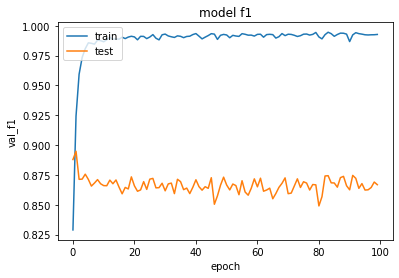

In [ ]:
plt.plot(history.history['f1'])
plt.plot(history.history['val_f1'])
plt.title('model f1')
plt.ylabel('val_f1')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

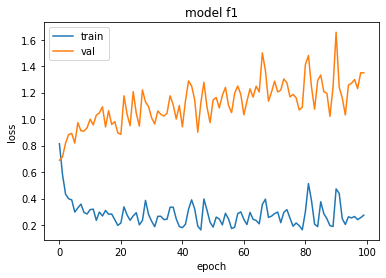

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model f1')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

# Model with Conv1D

In [ ]:
def build_CNN():
  model = Sequential()
  model.add(Embedding(num_vocab , 150, input_length = max_length)) #input_length = max_length
  model.add(Conv1D(256, 10, activation = 'relu'))
  model.add(MaxPool1D(5))
  model.add(Conv1D(256, 10, activation = 'relu'))
  model.add(GlobalMaxPool1D())
  model.add(Flatten())
  model.add(Dense(64, activation = 'relu', 
                  kernel_regularizer=regularizers.L1L2(l1=1e-5, l2=1e-4),
                  bias_regularizer=regularizers.L2(1e-4),
                  activity_regularizer=regularizers.L2(1e-5)))
  model.add(Dropout(0.5))
  model.add(Dense(4, activation = 'softmax'))
  return model
  

In [ ]:
model2 = build_CNN()
model2.compile(optimizer = Adam(), loss = 'categorical_crossentropy', metrics = [f1])
model2.summary()

Model: "sequential_20"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_20 (Embedding)    (None, 200, 150)          30000     
                                                                 
 conv1d_22 (Conv1D)          (None, 191, 256)          384256    
                                                                 
 max_pooling1d_11 (MaxPoolin  (None, 38, 256)          0         
 g1D)                                                            
                                                                 
 conv1d_23 (Conv1D)          (None, 29, 256)           655616    
                                                                 
 global_max_pooling1d_10 (Gl  (None, 256)              0         
 obalMaxPooling1D)                                               
                                                                 
 flatten_18 (Flatten)        (None, 256)             

In [ ]:
history2 = model2.fit(x = X_train, y = y_train, validation_data = (X_val, y_val),
          batch_size = 32,
          epochs = 100,
          verbose = 1)

Epoch 1/100
451/451 [==============================] - 13s 24ms/step - loss: 0.6204 - f1: 0.7623 - val_loss: 0.4996 - val_f1: 0.8500
Epoch 2/100
451/451 [==============================] - 9s 19ms/step - loss: 0.4689 - f1: 0.8397 - val_loss: 0.4739 - val_f1: 0.8330
Epoch 3/100
451/451 [==============================] - 9s 19ms/step - loss: 0.4229 - f1: 0.8582 - val_loss: 0.5087 - val_f1: 0.8415
Epoch 4/100
451/451 [==============================] - 9s 19ms/step - loss: 0.3779 - f1: 0.8719 - val_loss: 0.5267 - val_f1: 0.8347
Epoch 5/100
451/451 [==============================] - 9s 19ms/step - loss: 0.3179 - f1: 0.8927 - val_loss: 0.5101 - val_f1: 0.8465
Epoch 6/100
451/451 [==============================] - 9s 20ms/step - loss: 0.2634 - f1: 0.9102 - val_loss: 0.6025 - val_f1: 0.8465
Epoch 7/100
262/451 [================>.............] - ETA: 3s - loss: 0.1998 - f1: 0.9344

KeyboardInterrupt: ignored

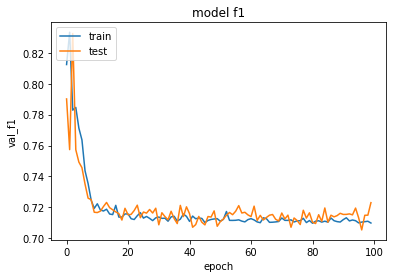

In [ ]:
plt.plot(history2.history['f1'])
plt.plot(history2.history['val_f1'])
plt.title('model f1')
plt.ylabel('val_f1')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

#Model with simple BiDirect - LSTM

In [ ]:
def build_BiLSTM_model():
  model = Sequential()
  model.add(Embedding(num_vocab , 128, input_length = max_length, mask_zero=True)) 
  model.add(tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(256)))
  model.add(Dense(64, activation = 'relu', 
                  kernel_regularizer=regularizers.L1L2(l1=1e-5, l2=1e-4),
                  bias_regularizer=regularizers.L2(1e-4),
                  activity_regularizer=regularizers.L2(1e-5)))
  model.add(Dense(4, activation = 'softmax'))
  return model 

In [ ]:
model3 = build_BiLSTM_model()
model3.compile(optimizer = Adam(), loss = 'categorical_crossentropy', metrics = [f1])
model3.summary()

Model: "sequential_22"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_22 (Embedding)    (None, 200, 256)          51200     
                                                                 
 bidirectional_3 (Bidirectio  (None, 512)              1050624   
 nal)                                                            
                                                                 
 dense_55 (Dense)            (None, 64)                32832     
                                                                 
 dense_56 (Dense)            (None, 4)                 260       
                                                                 
Total params: 1,134,916
Trainable params: 1,134,916
Non-trainable params: 0
_________________________________________________________________


In [ ]:
history3 = model3.fit(x = X_train, y = y_train, validation_data = (X_val, y_val),
          batch_size = 32,
          epochs = 100,
          verbose = 1)

Epoch 1/100
451/451 [==============================] - 809s 2s/step - loss: 0.5191 - f1: 0.8003 - val_loss: 0.4917 - val_f1: 0.8302
Epoch 2/100
451/451 [==============================] - 751s 2s/step - loss: 0.4137 - f1: 0.8534 - val_loss: 0.4704 - val_f1: 0.8418
Epoch 3/100
451/451 [==============================] - 757s 2s/step - loss: 0.3994 - f1: 0.8595 - val_loss: 0.4544 - val_f1: 0.8442
Epoch 4/100
451/451 [==============================] - 753s 2s/step - loss: 0.3811 - f1: 0.8656 - val_loss: 0.4418 - val_f1: 0.8458
Epoch 5/100
238/451 [==============>...............] - ETA: 5:57 - loss: 0.3641 - f1: 0.8720